In [1]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

In [2]:
from convert_mesh import convert_mesh


volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)

nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)

meshes/mesh_0.05.msh meshes/mesh_0.05.xdmf meshes/mesh_0.05_facet.xdmf

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
def run(volume_file: str, facet_file: str) -> float:
    from script_festim_1 import run_festim_1
    import time

    start = time.perf_counter()
    run_festim_1(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

In [4]:
import ipyparallel as ipp
import numpy as np
import os

if "CI" in os.environ:
    num_procs = [1, 2]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")

    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    print(elapsed_times)

    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    # get the maximum runtime
    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

# save data to csv
import pandas as pd
df = pd.DataFrame(data={"num_procs": num_procs, "runtimes": runtimes})
df.to_csv("runtimes_festim_1.csv", index=False)

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.85s/engine]
[59.91302071099926]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 381112, 'identifier': 'ipcontroller-1731602641-71mx-377959'}
Stopping engine(s): 1731602642
Output for ipengine-1731602641-71mx-1731602642-377959:
2024-11-14 11:44:02.986 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 11:44:02.987 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 11:44:03.034 [IPEngine] Registering with controller at tcp://127.0.0.1:52387
2024-11-14 11:44:03.036 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:56737', 'tcp://127.0.0.1:33055', 'tcp://127.0.0.1:53411']
2024-11-14 11:44:03.036 [IPEngine] Connecting shell to tcp://127.0.0.1:56737
2024-11-14 11:44:03.037 [IPEngine] Connecting shell to tcp://127.0.0.1:33055
2024-11-14 11:44:03.037 [IPEngine] Connecting shell to tcp://127.0.0.1:53411
2024-11-1

/tmp/ipykernel_377959/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.77s/engine]
[346.61012865099474, 346.612273875995]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 382189, 'identifier': 'ipcontroller-1731602712-lgc2-377959'}
Stopping engine(s): 1731602713
Output for ipengine-1731602712-lgc2-1731602713-377959:
2024-11-14 11:45:13.717 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 11:45:13.717 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 11:45:13.717 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 11:45:13.717 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 11:45:13.734 [IPEngine.0] Registering with controller at tcp://127.0.0.1:38617
2024-11-14 11:45:13.734 [IPEngine.1] Registering with controller at tcp://127.0.0.1:38617
2024-11-14 11:45:13.735 [IPEngine.0] Requesting id: 0
2024-11-14 11:45:13.735 [IPEngine.1] Requesting id: 1
2024-11-14 1

/tmp/ipykernel_377959/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.39s/engine]
[360.1950018429998, 360.2055916210011, 360.19491018400004, 360.19549506100157]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 386296, 'identifier': 'ipcontroller-1731603069-4s6d-377959'}
Stopping engine(s): 1731603070
Output for ipengine-1731603069-4s6d-1731603070-377959:
2024-11-14 11:51:10.555 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 11:51:10.558 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 11:51:10.558 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 11:51:10.557 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 11:51:10.557 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 11:51:10.576 [IPEngine.0] Registering with controller at tcp://127.0.0.1:38157
2024-11-14 11:51:10.576 [IPEngine.1] Registering with controller at tcp://127.0.0.1:38157
2024-11

/tmp/ipykernel_377959/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.43engine/s]
[643.1929121870053, 643.1860788519989, 643.1655862650005, 643.1884723890034, 643.1871882310006, 643.1526370280044, 643.1541905190024, 643.1771501740004]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 391183, 'identifier': 'ipcontroller-1731603439-8a1i-377959'}
Stopping engine(s): 1731603440
Output for ipengine-1731603439-8a1i-1731603440-377959:
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-14 11:57:21.572 [IPEngine.1] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 11:57:21.574 [IPEngine.0] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-14 11:57:21.576 [IPEngine.0] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 11:57:21.599 [IPEng

/tmp/ipykernel_377959/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.75engine/s]
[808.5044375190046, 808.519959244004, 808.6085954480004, 808.5731343270018, 808.4634559499973, 808.6425970089986, 808.4619963069999, 808.5504063550034, 808.5827225999965, 808.5797730160048, 808.6024752480007, 808.6064617189986, 808.5609739069987, 808.5016490769995, 808.3805175079979, 808.3340982360023]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 399923, 'identifier': 'ipcontroller-1731604093-9wkr-377959'}
Stopping engine(s): 1731604094
Output for ipengine-1731604093-9wkr-1731604094-377959:
2024-11-14 12:08:15.947 [IPEngine.7] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 12:08:15.948 [IPEngine.1] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-14 12:08:15.949 [IPEngine.0] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-14 12:08:15.949 [IPEngine

/tmp/ipykernel_377959/3282433569.py:28: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


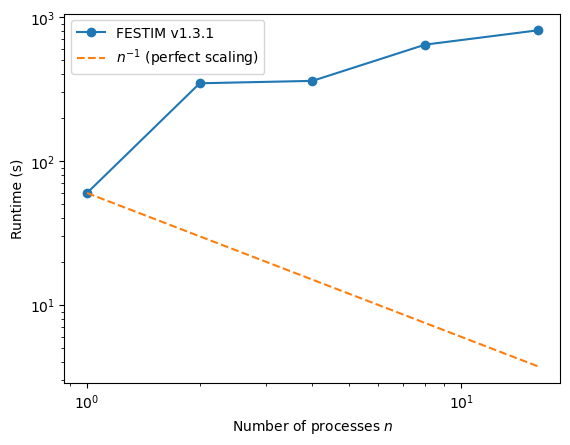

In [5]:
import matplotlib.pyplot as plt
from festim import __version__

plt.plot(num_procs, runtimes, marker="o", label=f"FESTIM v{__version__}")

n = np.linspace(1, 16, 100)
plt.plot(n, runtimes[0] * n**-1, linestyle="--", label="$n^{-1}$ (perfect scaling)")

plt.xlabel("Number of processes $n$")
plt.ylabel("Runtime (s)")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()